## Heat Equation
#### Parameter estimation for the heat equation (no source) using Gaussian processes (Backward Euler scheme)


#### Problem Setup

$u_t - \alpha u_{xx} = 0$

$u(x,t) = e^{-t}sin(\frac{x}{\sqrt{\alpha}})$

$u_0(x) := u(x,0) = sin(\frac{x}{\sqrt{\alpha}})$

$x \in [0, 2\pi \sqrt{\alpha}], t \in [0,1]$

Using the backward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} - \alpha \frac{d^2}{dx^2}u_n = 0$

and so:

$u_n - \tau \alpha \frac{d^2}{dx^2}u_n = u_{n-1}$


Consider $u_n$ to be a Gaussian processes.

$u_n \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^\alpha = \cdot - \tau \alpha \frac{d^2}{dx^2}\cdot$

so that

$\mathcal{L}_x^\alpha u_n = u_{n-1}$

Problem at hand: estimate $\alpha$.

For the sake of simplicity, take $u := u_n$ and $f := u_{n-1}$.


#### step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

$\alpha = 1$ and $x \in (0,2\pi)$.

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
tau = 0.02
alpha = 1
def get_simulated_data(tau, alpha):
    x = 2*np.pi*np.sqrt(alpha)*np.random.rand(20)
    y_u = np.exp(-tau)*np.sin(x/np.sqrt(alpha))
    y_f = np.sin(x/np.sqrt(alpha))
    return (x, y_u, y_f)

(x, yu, yf) = get_simulated_data(tau, alpha)

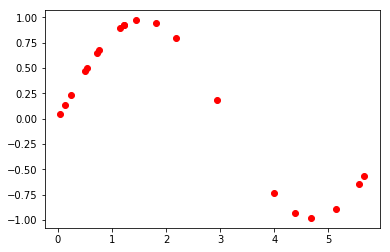

In [3]:
plt.plot(x, yu, 'ro')
plt.show()

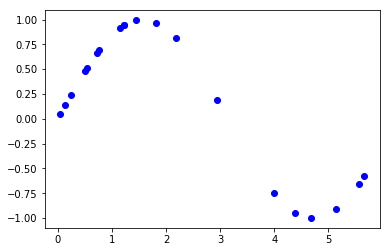

In [4]:
plt.plot(x, yf, 'bo')
plt.show()

#### Step 2:Evaluate kernels

$k_{nn}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2}(x_i-x_j)^2)$

In [5]:
x_i, x_j, theta, alpha = sp.symbols('x_i x_j theta alpha')
kuu_sym = theta*sp.exp(-1/(2)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta), kuu_sym, "numpy")
def kuu(x, theta):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\phi \mathcal{L}_{x_j}^\phi k_{uu}(x_i, x_j; \theta) \\
= \mathcal{L}_{x_i}^\phi \left( k_{uu} - \tau \alpha \frac{\partial^2}{\partial x_j^2}k_{uu} \right) \\
 = k_{uu} - \tau \alpha \left( \frac{\partial^2}{\partial x_j^2} + \frac{\partial^2}{\partial x_i^2} \right)k_{uu} + \tau^2 \alpha^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$

In [6]:
kff_sym = kuu_sym \
        - tau*alpha*(sp.diff(kuu_sym, x_j, x_j) \
        + sp.diff(kuu_sym, x_i, x_i)) \
        + tau**2*alpha**2*sp.diff(kuu_sym, x_j, x_j, x_i, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, alpha), kff_sym, "numpy")
def kff(x, theta, alpha):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, alpha)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\alpha k_{uu}(x_i, x_j; \theta) \\
= k_{uu} - \tau \alpha \frac{\partial^2}{\partial x_i^2}k_{uu} $

In [7]:
kfu_sym = kuu_sym - tau*alpha*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, alpha), kfu_sym, "numpy")
def kfu(x, theta, alpha):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, alpha)
    return k

In [8]:
def kuf(x, theta, alpha):
    return kfu(x,theta,alpha).T

#### Step 3: Compute NLML

In [9]:
def nlml(params, x, y1, y2, s):
    K = np.block([
        [kuu(x, params[0]) + s*np.identity(x.size), kuf(x, params[0], params[1])],
        [kfu(x, params[0], params[1]), kff(x, params[0], params[1]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [10]:
nlml((1, 2), x, yu, yf, 1e-6)

688.6084526775235

#### Step 4: Optimise hyperparameters

In [12]:
minimize(nlml, np.random.rand(2), args=(x, yu, yf, 1e-6), method="Nelder-Mead")

 final_simplex: (array([[0.21646742, 1.01066369],
       [0.21637383, 1.01066517],
       [0.21648356, 1.01067997]]), array([-206.22261544, -206.22261537, -206.22261512]))
           fun: -206.2226154437473
       message: 'Optimization terminated successfully.'
          nfev: 67
           nit: 35
        status: 0
       success: True
             x: array([0.21646742, 1.01066369])

### Some analysis [to-do]

Predicted values of $\alpha$ against time steps.